<a href="https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/tf2/tf-basics-regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# From Low to High with TensorFlow 2

## Objectives

- how matrix multiplication is the basis of neural networks
- how loss functions work
- backpropagation
- optimizers
- regression

Hosted on Colab: http://colab.research.google.com/

In [0]:
import matplotlib.pyplot as plt
# plt.xkcd()
# plt.style.use('ggplot')
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)

### Challenge: How do we fit the best line possible?

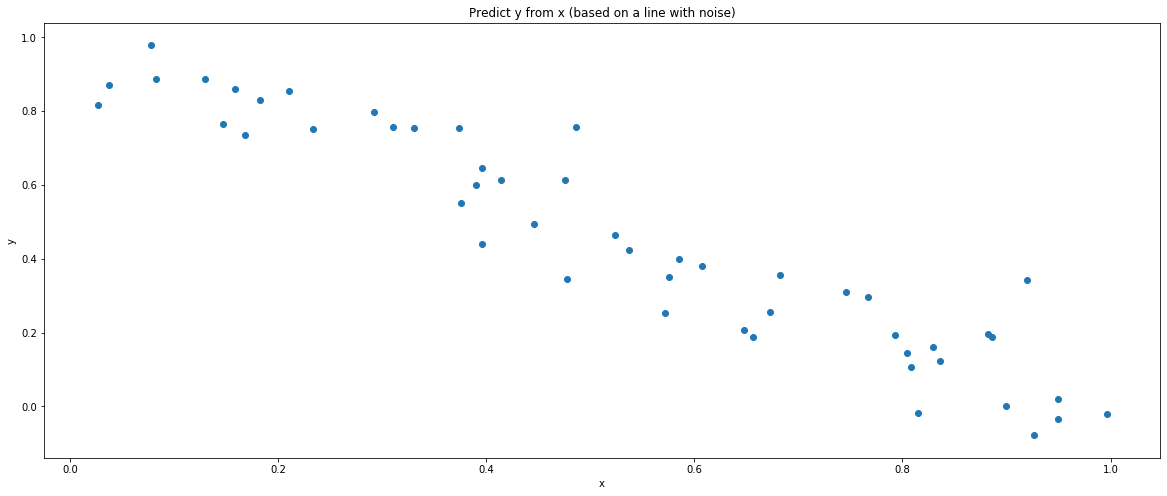

In [2]:
#@title A noisy line of shape y = m*x + b { run: "auto", display-mode: "form" }

# https://colab.research.google.com/notebooks/forms.ipynb

n = 50 #@param {type:"slider", min:10, max:500, step:1}
m = -1 #@param {type:"slider", min:-10, max:10, step: 0.1}
b = 1 #@param {type:"slider", min:-10, max:10, step: 0.1}

noise_level = 0.1 #@param {type:"slider", min:0.1, max:1.0, step:0.1}

title = 'Predict y from x (based on a line with noise)' #@param {type:"string"}
x_label = 'x' #@param {type:"string"}
y_label = 'y' #@param {type:"string"}

import numpy as np

x = np.random.uniform(0, 1, n)
y = m*x+b + np.random.normal(0, noise_level, n)

plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(title)

plt.scatter(x, y);

## Exercise: Get familiar with Colab notebooks and the example

* Execute all cells up to this point by pressing shift+enter in each cell
* Change the title and what is on the axis to match any application you might have
* Play with the parameters using the sliders above to get an idea of what kind of problem we are dealing with
* If the data does not match your application, adjust it in a reasonable way

# Starting off with a naive approach

## Our model: linear

### ```y = m*x + b```

* `m` is the slope 
* `b` is the y-intercept


In [0]:
class LinearModel:
  
  def __init__(self, m=0, b=0):
    self.m = m
    self.b = b
    
  def __call__(self, x):
    y = self.m * x + self.b
    return y

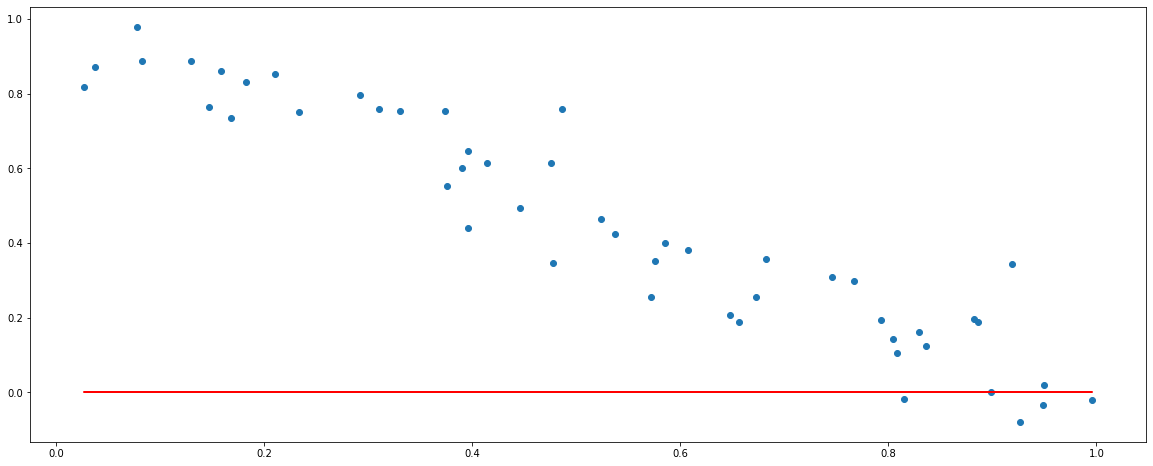

In [4]:
model = LinearModel()
y_pred = model(x)
plt.plot(x, y_pred, color='r')
plt.scatter(x, y);

## How wrong are we?
### This is obviously wrong, but how wrong are we?

In [5]:
def loss1(y_true, y_pred):
  return np.sum(y_true - y_pred)
loss1(y, y_pred)

22.582696967969564

In [6]:
def loss_no_negative(y_true, y_pred):
  return np.sum(np.abs(y_true - y_pred))
loss_no_negative(y, y_pred)

22.881206947959935

In [7]:
def loss_no_negative_normalize(y_true, y_pred):
  return np.sum(np.abs(y_true - y_pred)) / len(y_true)
loss_no_negative_normalize(y, y_pred)

0.4576241389591987

## Approach: Trying to bring the loss down in loop

Parameters to tweak
* m for the slope
* b for the y-intercept

### Let's begin with naive implementation

1. if we bring m or b up or down, does this improve the loss?
1. if so, do it
1. rinse and repeat for a number of times

In [8]:
model = LinearModel()

EPOCHS = 500
learning_rate = 0.01

losses = []

for step in range(EPOCHS):
  y_pred = model(x)
  
  loss = loss_no_negative_normalize(y, y_pred)
    
  # just for logging
  losses.append(loss)
  
  # let's try m
  new_model = LinearModel(m = model.m + learning_rate, b = model.b)
  new_y_pred = new_model(x)
  new_loss = loss_no_negative_normalize(y, new_y_pred)
  
  if new_loss < loss:
    model.m += learning_rate
  else:
    model.m -= learning_rate
    
  # then b
  new_model = LinearModel(m = model.m, b = model.b + learning_rate)
  new_y_pred = new_model(x)
  new_loss = loss_no_negative_normalize(y, new_y_pred)
  
  if new_loss < loss:
    model.b += learning_rate
  else:
    model.b -= learning_rate


model.m, model.b    

(-1.0200000000000007, 1.0000000000000007)

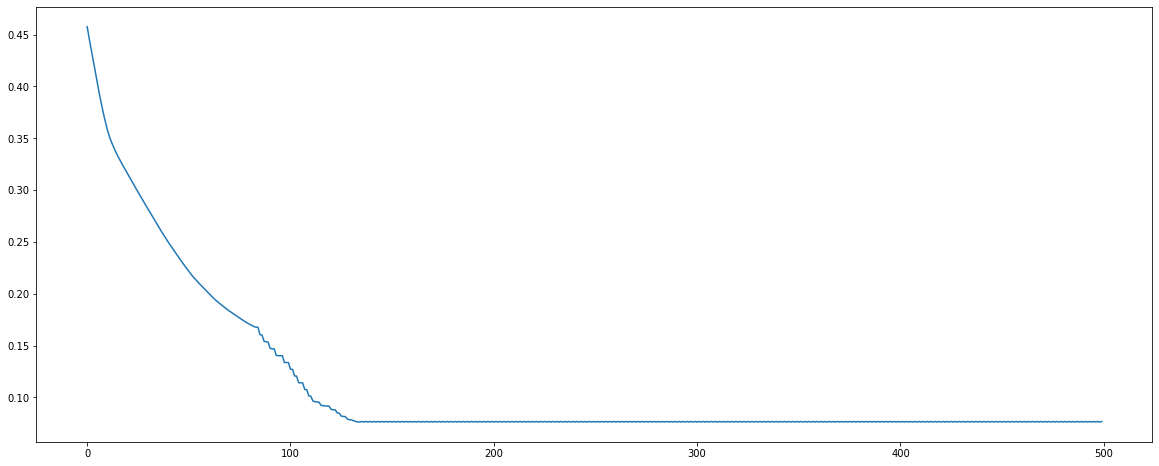

In [9]:
# plt.yscale('log')
plt.plot(losses);

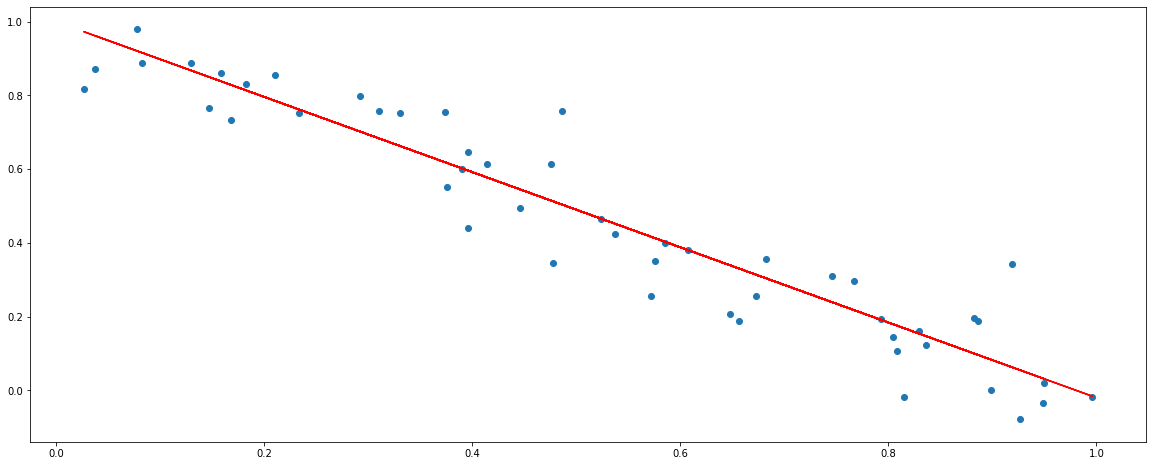

In [10]:
y_pred = model(x)
plt.plot(x, y_pred, color='r')
plt.scatter(x, y);

# We already have a working solution

## But does this scale to an example with many more parameters and more inputs?

1. Calculating the output might be expensive
2. Trying out all parameters in a random we like we do would have a bad performance for a large problem
3. Wouldn't we also need to try them in combination?

# Let's see what we need to change for this to become a state of the art neural network using TensorFlow 2

1. Replace our model with a fully connected layer
2. Use a standard loss function
3. Finding parameters to tune
4. Changing parameters

In [11]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.__version__

TensorFlow 2.x selected.


'2.0.0'

## Step one: use a dense layer instead of our simple model
* Scales well for as many neurons and inputs as we want
* Efficient implementation on GPUs



### The Artificial Neuron: Foundation of Deep Neural Networks (simplified, more later)

* a neuron takes a number of numerical inputs
* multiplies each with a weight, sums up all weighted input and  
* adds bias (constant) to that sum
* from this it creates a single numerical output
* for one input (one dimension) this would be a description of a line
* for more dimensions this describes a hyper plane that can serve as a decision boundary
* this is typically expressed as a matrix multplication plus an addition


<img src='https://djcordhose.github.io/ai/img/insurance/neuron211.jpg'>

### This can be expressed using a matrix multiplication

In [12]:
%%time 

# parameters of the neuron (can be learned), defining the function to apply
w = tf.constant([[1.5], [-2], [1]], dtype='float32')
b = tf.constant([6], dtype='float32')

# variable input being fed through the parameterized neuron
example_x = tf.constant([[10, 6, 8]], dtype='float32')

# computed output
example_y = tf.matmul(example_x, w) + b
print(example_y)

tf.Tensor([[17.]], shape=(1, 1), dtype=float32)
CPU times: user 407 ms, sys: 307 ms, total: 713 ms
Wall time: 747 ms


### Defining a dense layer with a random number of neurons and inputs

With a little more work this would be a complete implementation of a fully connected layer



In [13]:
from tensorflow.keras.layers import Layer

# we derive from a TensorFlow Layer
class LinearLayer(Layer):
  """y = w.x + b"""

  # initializing our layer
  def __init__(self, units=1, input_dim=1):
      super(LinearLayer, self).__init__()
      # these are our weights, which can be learned, initialized normally around 0 with stddev of 2
      self.w = tf.Variable(
          initial_value = tf.random_normal_initializer(stddev=2)(shape=(input_dim, units), dtype='float32'),
          trainable=True,
          name='weights')
      # these are our bisases, also can be learned, initialized as 0
      self.b = tf.Variable(
          initial_value = tf.zeros_initializer()(shape=(units,), dtype='float32'),
          trainable=True,
          name='biases')

  # what the layer does (some as in our example before)
  def call(self, inputs):
      return tf.matmul(inputs, self.w) + self.b
    
# just one neuron and one input (but could be as many as we like)    
linear_layer = LinearLayer()
linear_layer.trainable_variables

[<tf.Variable 'weights:0' shape=(1, 1) dtype=float32, numpy=array([[-2.8258467]], dtype=float32)>,
 <tf.Variable 'biases:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

### Same prediction as before, but now on GPU using scalable matrix multiplcation

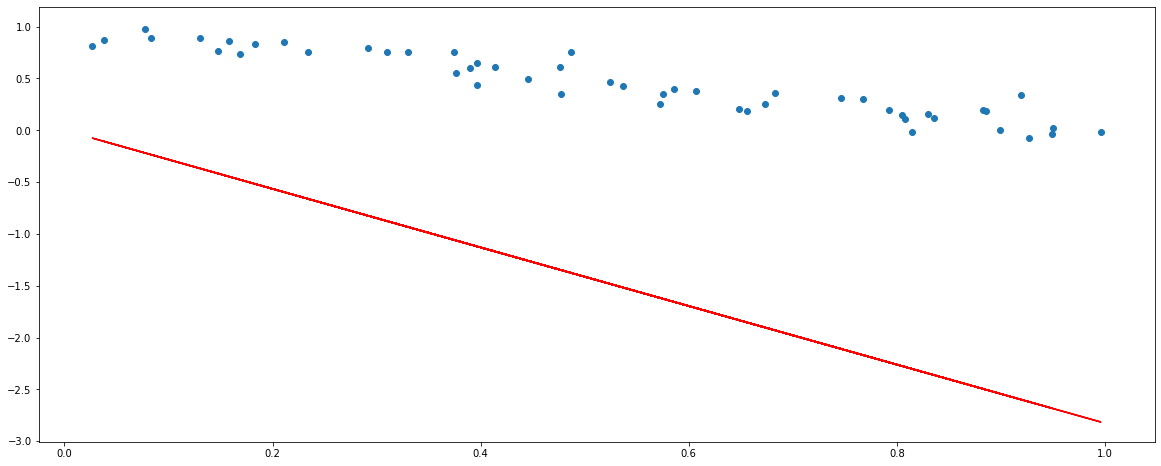

In [14]:
x_tensor = tf.reshape(tf.constant(x, dtype=tf.float32), (n, 1))
y_tensor = tf.reshape(tf.constant(y, dtype=tf.float32), (n, 1))

y_pred = linear_layer(x_tensor)
plt.plot(x, y_pred, color='r')
plt.scatter(x, y);

In [15]:
# you can see slope and offset are just not right
slope = linear_layer.w; offset = linear_layer.b
slope.numpy(), offset.numpy()

(array([[-2.8258467]], dtype=float32), array([0.], dtype=float32))

## Step two: use standard loss and metric
* what we defined is called mean absolute error: mae
* mean squared error is more common, it squares the differences and gives high values a larger weight: mse
* both are pre-defined efficiently in TensorFlow 2

### Mean Absolute Error

In [16]:
tf.losses.mean_absolute_error(y_true=tf.squeeze(y), y_pred=tf.squeeze(y_pred))

<tf.Tensor: id=76, shape=(), dtype=float32, numpy=1.9490802>

### Mean Squared Error

$MSE = {\frac {1}{n}}\sum _{i=1}^{n}(Y_{i}-{\hat {Y_{i}}})^{2}$


https://en.wikipedia.org/wiki/Mean_squared_error


In [17]:
tf.losses.mean_squared_error(y_true=tf.squeeze(y), y_pred=tf.squeeze(y_pred))

<tf.Tensor: id=83, shape=(), dtype=float32, numpy=4.072305>

### R2 Metric: MSE and MAE are not speaking

* R^2 score, the closer to 1 the better
* loosely speaking: how much better is this than predicting the constant mean
* 0 would mean just as good
* 1 is perfect
* neg. would mean even worse
* it can become arbitrarily worse

https://en.wikipedia.org/wiki/Coefficient_of_determination


In [0]:
# https://keras.io/metrics/#custom-metrics

# ported to TF 2 from 
# * https://stackoverflow.com/a/42351397/1756489 and
# * https://www.kaggle.com/c/mercedes-benz-greener-manufacturing/discussion/34019 (for use of epsilon to avoid strange inf or -inf)

# only works properly on tensors

def r2_metric(y_true, y_pred):
  total_error = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
  unexplained_error = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
  R_squared = tf.subtract(1.0, tf.divide(unexplained_error, tf.add(total_error, tf.keras.backend.epsilon())))
  
  return R_squared

In [19]:
r2_metric(y_true=tf.squeeze(y_tensor), y_pred=tf.squeeze(y_pred))

<tf.Tensor: id=100, shape=(), dtype=float32, numpy=-43.47645>

## Step three: Finding parameters to tune

## Backpropagation algorithm


### The core of how a neural network learns

_In a nutshell:_
1. Predict: Let the network make a prediction 
1. Calculate the loss: how accurate was the predition
1. Record a function of how the trainable parameters affect the loss 
1. partial derivations: find out in which direction to change all parameters to bring down the loss
1. Optimizer: Make changes to parameters based on learning rate and other parameters


### Loss depends on the trainable variables, in our case two parameters: weight and bias

This is how the loss function might change depending on those variables

<img src='https://github.com/DJCordhose/ml-workshop/raw/master/img/convex_cost_function.jpg'>

https://blog.paperspace.com/intro-to-optimization-in-deep-learning-gradient-descent/

<img src='https://djcordhose.github.io/ai/img/gradients.jpg'>

https://twitter.com/colindcarroll/status/1090266016259534848

In [20]:
linear_layer.trainable_variables

[<tf.Variable 'weights:0' shape=(1, 1) dtype=float32, numpy=array([[-2.8258467]], dtype=float32)>,
 <tf.Variable 'biases:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

### For this we need partial derivations

TensorFlow offers automatic differentiation: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/GradientTape

* tape will record operations for automatic differentiation
* either by making it record explicily (watch) or 
* by declaring a varible to be trainable (which we did in the layer above) 



In [0]:
from tensorflow import GradientTape 
GradientTape?

In [22]:
def tape_sample():
  x = tf.Variable(3.0)
  with tf.GradientTape() as tape:
    y = x * x
  print(x, y)
  # how is y dependending on x
  dy_dx = tape.gradient(y, x)
  print(dy_dx)
  
# just a function in order not to interfere with x on the global scope  
tape_sample()

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=3.0> tf.Tensor(9.0, shape=(), dtype=float32)
tf.Tensor(6.0, shape=(), dtype=float32)


### Short Exercise: create your own example

* first understand the example above: do the values make sense to you?
* change the value for x
* create your own function from x to y
* add another variable y depdends on
* if you want to use typical math functions (like sin or cos), you need to use `tf` as prefix

In [23]:
import math

def tape_sample():
  x = tf.Variable(math.pi)
  with tf.GradientTape() as tape:
#     y = math.sin(x)
    y = tf.sin(x) # when you use mathematical functions, you need to use the tensorflow version
  print(x, y)
  # how is y dependending on x
  dy_dx = tape.gradient(y, x)
  print(dy_dx)
  
# just a function in order not to interfere with x on the global scope  
tape_sample()

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=3.1415927> tf.Tensor(-8.742278e-08, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)


## Intermediate solution: applying all this to our training loop

In [0]:
linear_layer = LinearLayer()

EPOCHS = 1500
learning_rate = 0.01

losses = []
r2s = []

for step in range(EPOCHS):
  with tf.GradientTape() as tape:

    # forward pass, all data
    # often we do not use all data to calculate the loss, but only a certain fraction, called the batch
    # you could also push data through one by one, being an extreme version of a batched approached
    # in our case we use all the data we have and calculate the combined error
    y_pred = linear_layer(x_tensor)

    # loss for this batch
    loss = tf.losses.mean_squared_error(y_true=tf.squeeze(y_tensor), y_pred=tf.squeeze(y_pred))
    
  # just for logging
  losses.append(loss)
  r2 = r2_metric(y_true=tf.squeeze(y_tensor), y_pred=tf.squeeze(y_pred))
  r2s.append(r2)

  # get gradients of weights wrt the loss
  (dw, db) = tape.gradient(loss, linear_layer.trainable_weights)
  
  # optimizer: backward pass, changing trainable weights in the direction of the mimimum
  linear_layer.w.assign_sub(learning_rate * dw)
  linear_layer.b.assign_sub(learning_rate * db)

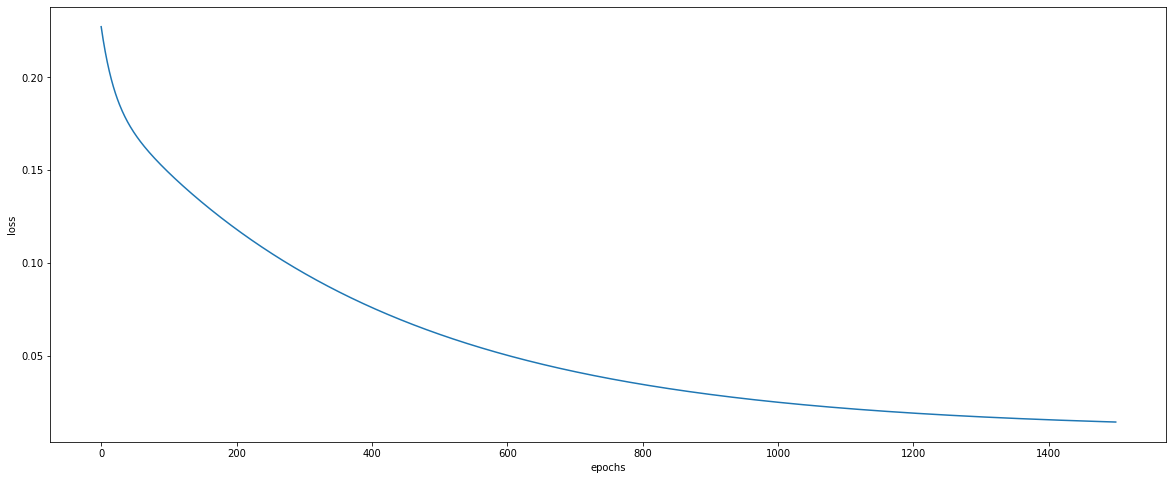

In [25]:
plt.xlabel('epochs')
plt.ylabel('loss')

# plt.yscale('log')

plt.plot(losses);

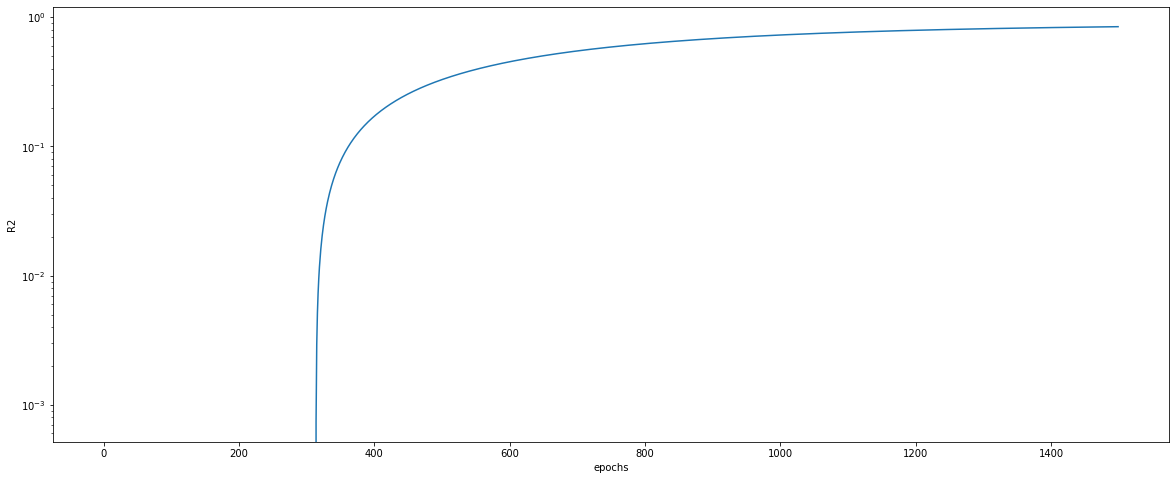

In [26]:
plt.xlabel('epochs')
plt.ylabel('R2')

plt.yscale('log')

plt.plot(r2s);

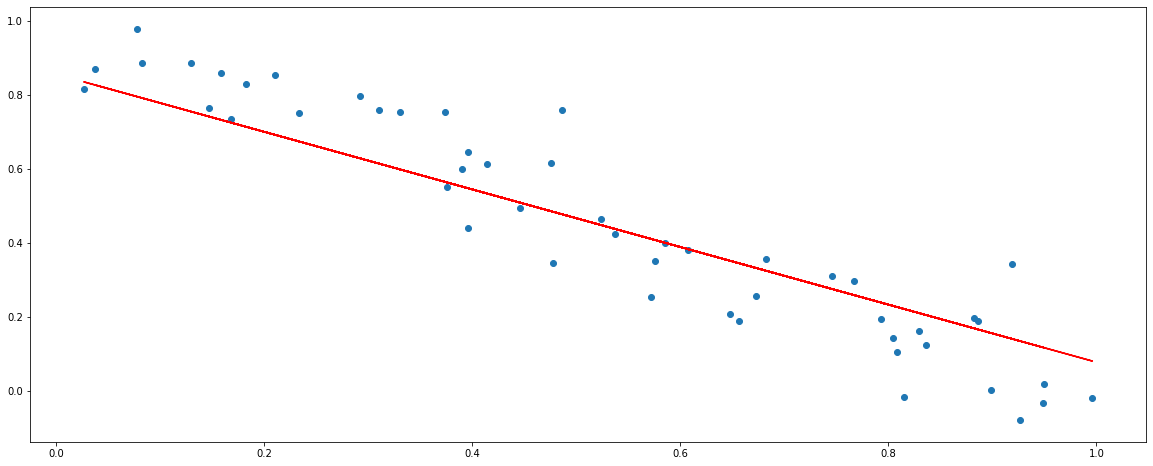

In [27]:
y_pred = linear_layer(x_tensor)
plt.plot(x, y_pred, color='r')
plt.scatter(x, y);

## Final step: Changing parameters

## Prebuilt Optimizers do this job (but a bit more efficient and sohpisticated)

* http://cs231n.github.io/optimization-1/
* http://cs231n.github.io/neural-networks-3/#update
* How they sound: http://blog.christianperone.com/2019/08/listening-to-the-neural-network-gradient-norms-during-training/

In [0]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2)

In [0]:
EPOCHS = 1500

losses = []
r2s = []

linear_layer = LinearLayer()

for step in range(EPOCHS):
  with tf.GradientTape() as tape:

    # forward pass, all data
    y_pred = linear_layer(x_tensor)

    # loss for this batch
    loss = tf.losses.mean_squared_error(y_true=tf.squeeze(y_tensor), y_pred=tf.squeeze(y_pred))
    
  # just for logging
  losses.append(loss)
  r2 = r2_metric(y_true=tf.squeeze(y_tensor), y_pred=tf.squeeze(y_pred))
  r2s.append(r2)

  # Get gradients of weights wrt the loss.
  gradients = tape.gradient(loss, linear_layer.trainable_weights)
  
  # Update the weights of our linear layer.
  optimizer.apply_gradients(zip(gradients, linear_layer.trainable_weights))

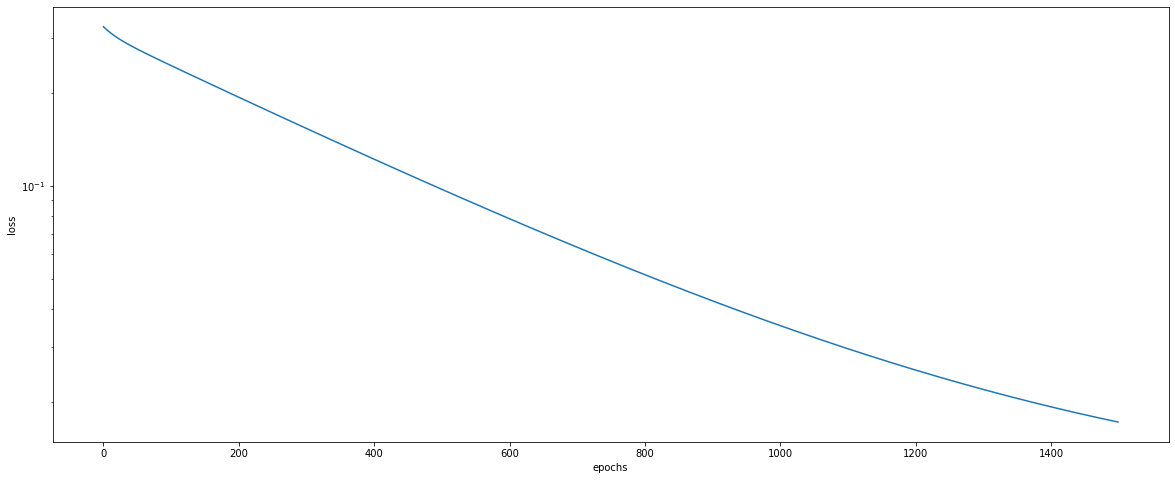

In [30]:
plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")

plt.plot(losses);

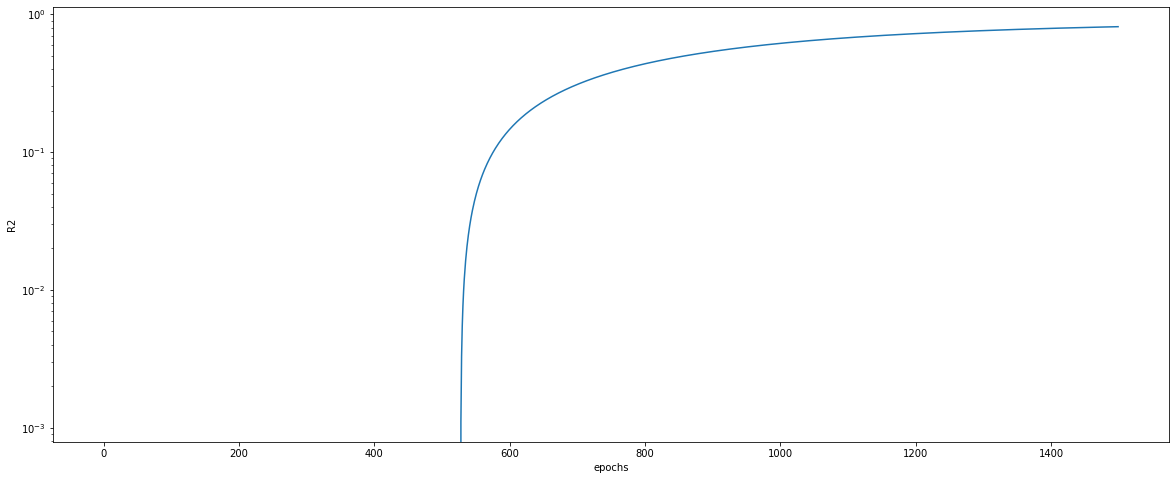

In [31]:
plt.xlabel('epochs')
plt.ylabel('R2')

plt.yscale('log')

plt.plot(r2s);

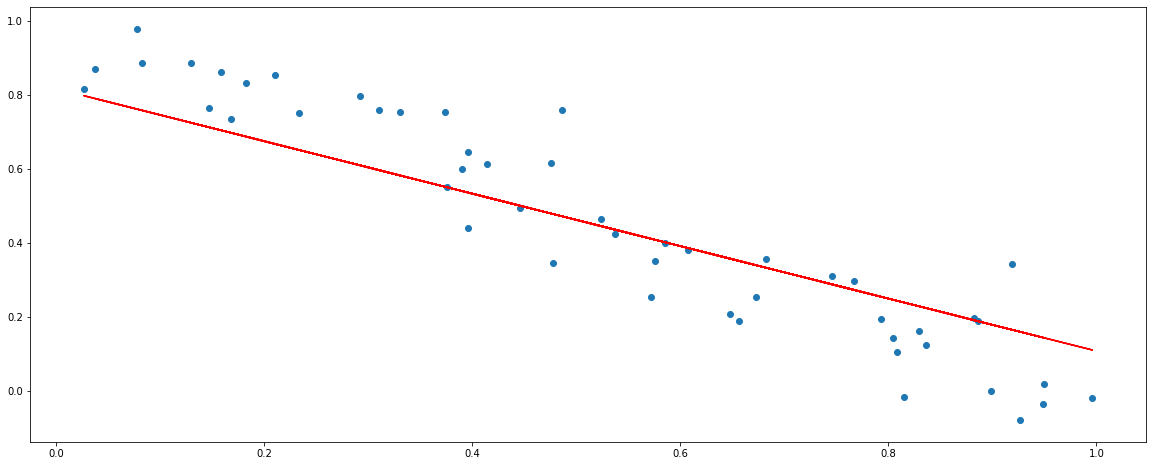

In [32]:
y_pred = linear_layer(x_tensor)
plt.plot(x, y_pred, color='r')
plt.scatter(x, y);

## The same solution using high level Keas API

In [33]:
from tensorflow.keras.layers import Dense
 
model = tf.keras.Sequential([
  Dense(units=1, input_dim=1)                   
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [34]:
%%time 

model.compile(loss=tf.losses.mean_squared_error, # mean squared error, unchanged from low level example
             optimizer=tf.keras.optimizers.SGD(learning_rate=1e-2), # SGD, unchanged from low level example
             metrics=[r2_metric]) # we can track the r2 metric over time

# does a similar thing internally as our loop from above
history = model.fit(x, y, epochs=1000, verbose=0)

CPU times: user 9.2 s, sys: 930 ms, total: 10.1 s
Wall time: 7.49 s


In [35]:
loss, r2 = model.evaluate(x, y, verbose=0)
loss, r2

(0.011320871189236642, 0.8714995)

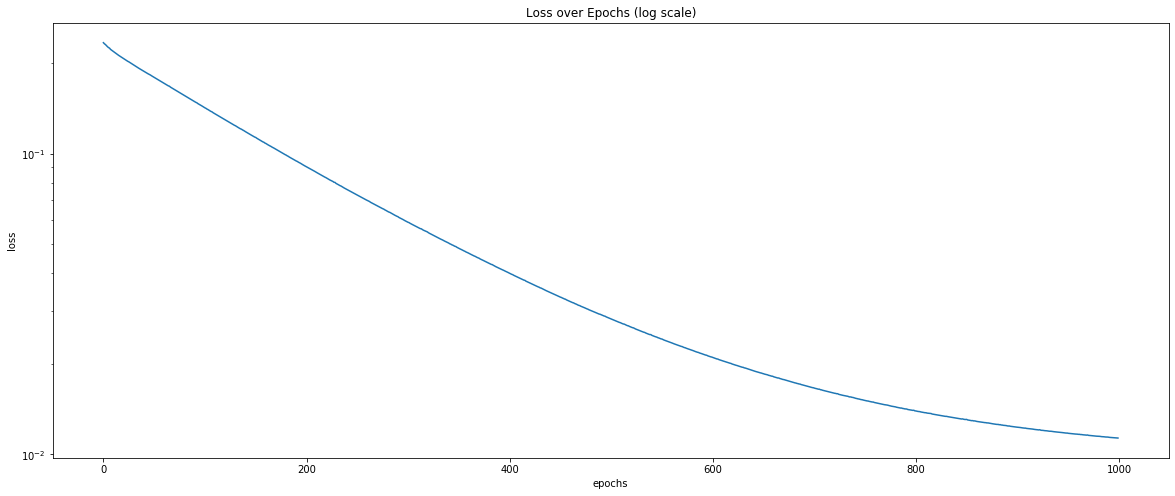

In [36]:
plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over Epochs (log scale)')

plt.plot(history.history['loss']);

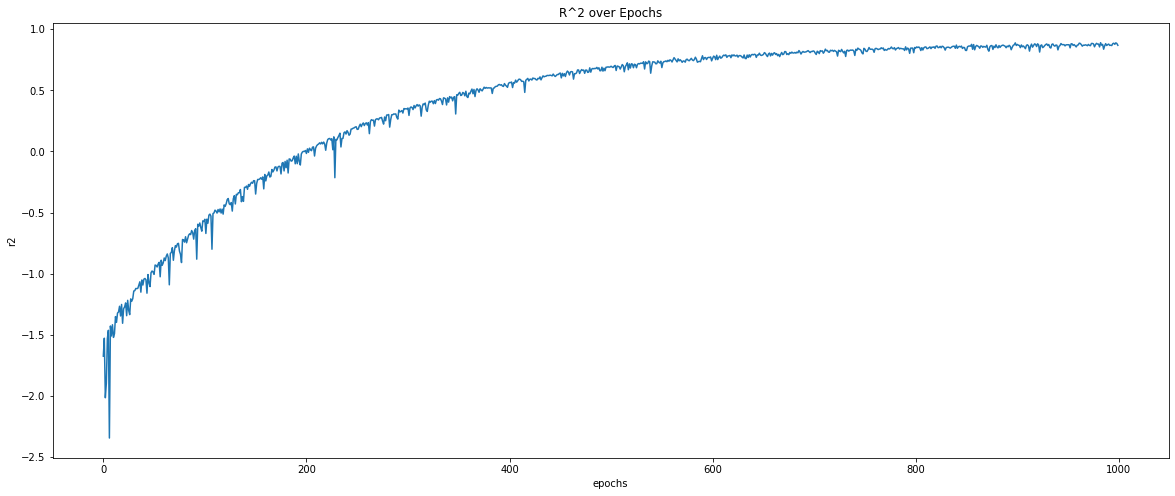

In [37]:
plt.ylabel("r2")
plt.xlabel("epochs")
plt.title('R^2 over Epochs')
# plt.yscale('log')

plt.plot(history.history['r2_metric']);

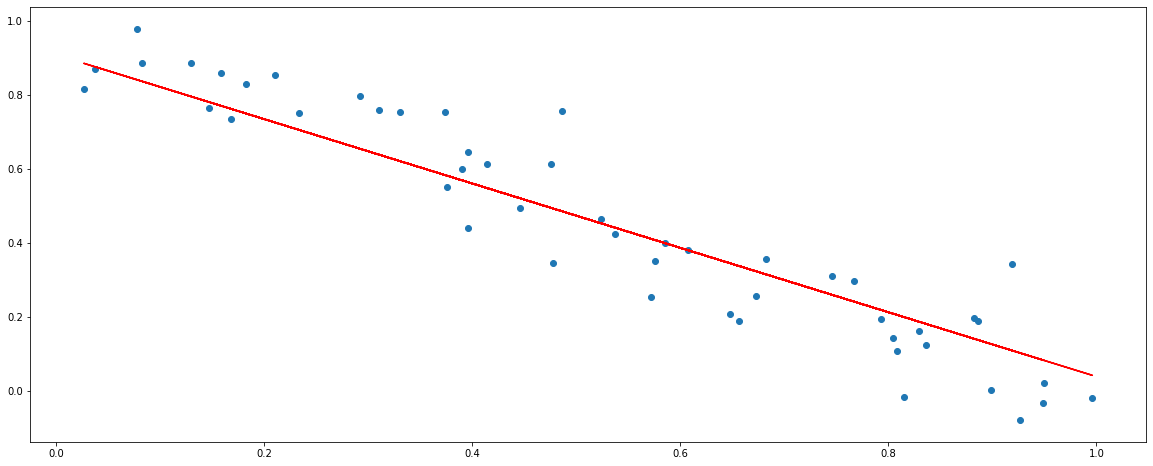

In [38]:
y_pred = model.predict(x)
plt.plot(x, y_pred, color='red')
plt.scatter(x, y);

### Exercise: Re-Run experiment with more noise

* run the cells above and train our model
* change the noise of the line and make it less line like
* can you still get good training results?
* how would you know? how is the loss and metric changing?
* can you get better by making the network more complex?

_Advanced_
* execute the section below
* create a complex function and make sure the network can approximate it

## Neural Networks with 2-3 Layers can learn to approximate any function
* no additional prior required
* theoretically only one layer is enough, but this will not always train

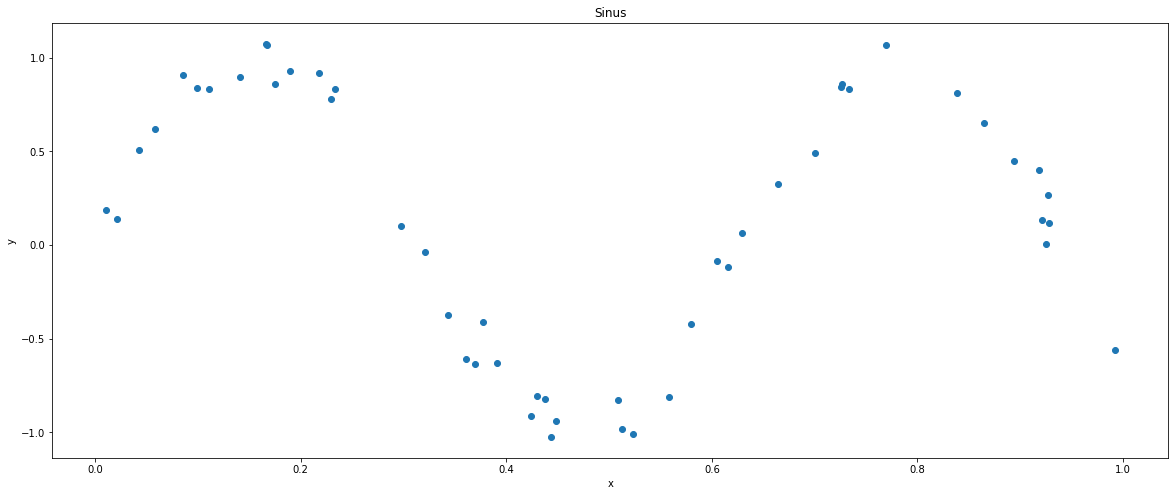

In [39]:
#@title A noisy sine curve { run: "auto", display-mode: "both" }

n = 50 #@param {type:"slider", min:10, max:500, step:1}
noise_level = 0.1 #@param {type:"slider", min:0.1, max:1.0, step:0.1}
scale = 10 #@param {type:"slider", min:1, max:100, step:1}

import numpy as np

x = np.random.uniform(0, 1, n)
y = np.sin(x*scale) + np.random.normal(0, noise_level, n)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Sinus')

plt.scatter(x, y);

In [40]:
%%time 
 
model = tf.keras.Sequential([
  Dense(units=100, activation='relu', input_dim=1),                   
  Dense(units=100, activation='relu'),
  Dense(units=100, activation='relu'),                   
  Dense(units=1, activation='linear')                   
])
model.summary()

model.compile(loss=tf.losses.mean_squared_error, # mean squared error, unchanged from low level example
             optimizer=tf.keras.optimizers.Adam(), # advanced loss function
             metrics=[r2_metric]) # we can track the r2 metric over time

# does a similar thing internally as our loop from above
history = model.fit(x, y, epochs=1000, verbose=0)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               200       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 20,501
Trainable params: 20,501
Non-trainable params: 0
_________________________________________________________________
CPU times: user 10.7 s, sys: 981 ms, total: 11.7 s
Wall time: 8.63 s


In [41]:
loss, r2 = model.evaluate(x, y, verbose=0)
loss, r2

(0.007294966224581003, 0.98452866)

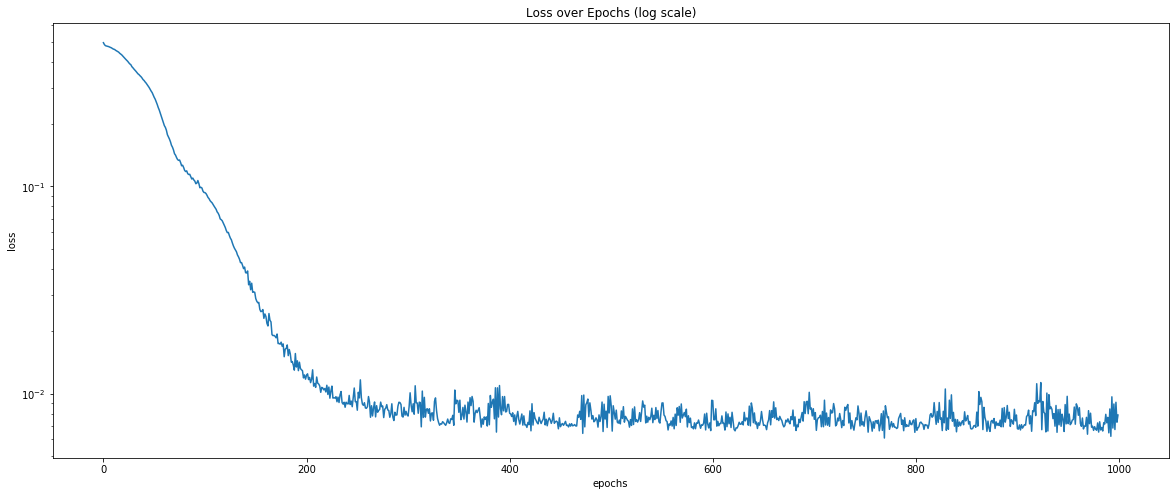

In [42]:
plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over Epochs (log scale)')

plt.plot(history.history['loss']);

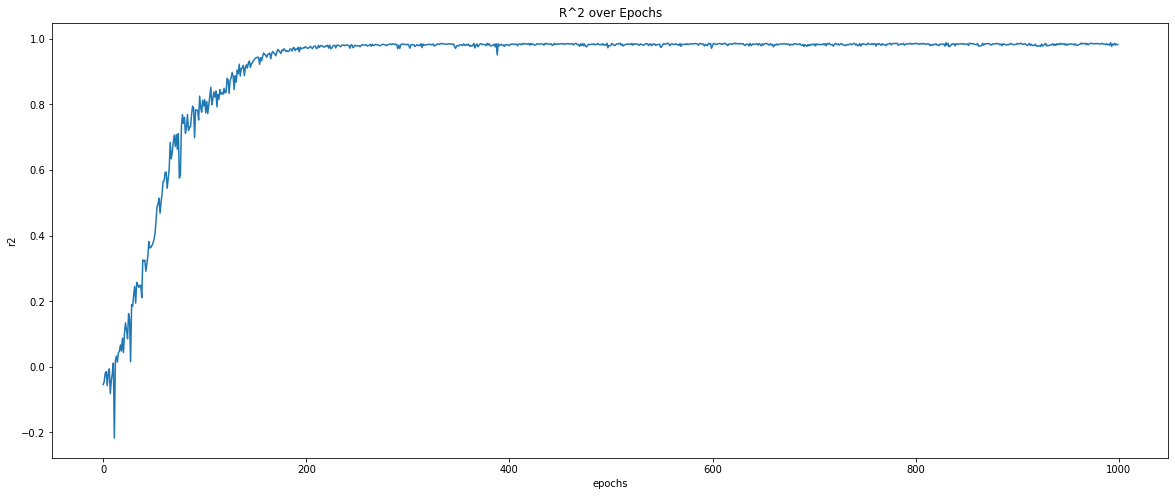

In [43]:
plt.ylabel("r2")
plt.xlabel("epochs")
plt.title('R^2 over Epochs')
# plt.yscale('log')

plt.plot(history.history['r2_metric']);

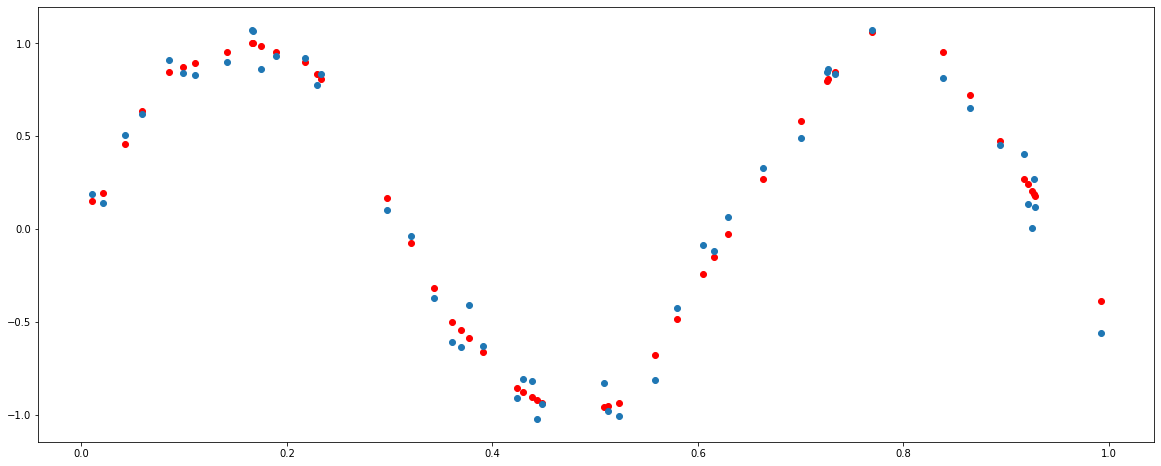

In [44]:
y_pred = model.predict(x)
plt.scatter(x, y_pred, color='red')
plt.scatter(x, y);